# ch 3 word2vec

추론 기반 기법 으로 단어의 분산표현을 얻는 방법.  
$word2vec$ 라는 신경망을 이용


단어를 벡터로 표현 하는 것
1. 통계 기반 기법
2. 추론 기반 기법 

단어의 의미를 얻는 방식은 서로 크게 다르지만, 그 배경에는 보두 '분포 가설'이 있다.

## 3.1 추론 기반 기법과 신경망

### 신경망에서의 단어 처리
단어를 고정 길이의 벡터로 변환. 이떄 사용하는 대표적읜 방법이 원핫 표현으로 변환하는 것.  
원핫 표현: 벡터의 원소 중 하나만 1이고 나머지는 모르 0인 벡터.  

단어는 텍스트, 단어 ID, 그리고 원핫 표현 형태로 나타낼 수 있다. 
단어--> 원핫 표현
1. 총 어휘 수만큼의 원소를 갖는 벡터 준비
2. 인덱스가 단어 ID와 같은 원소를 1로, 나머지를 모두 0으로 설정
- 이처럼 단어를 고정 길이 벡터로 변환하면 신경망의 입력층은 뉴런의 수를 '고정'할 수 있다

In [1]:
import numpy as np
# 완전연결계층에 의한 파이썬
# 완전연결계층의 계산은 행렬 곱으로 수행 가능
c = np.array([1,0,0,0,0,0,0]) # 입력
W = np.random.randn(7,3)
h = np.matmul(c,W)
print(h)

[ 0.26885978 -0.80201948 -0.01112254]


c와 W의 행렬 곱 부분을 주목해서 봐야한다. c는 원핫 표현이므로 단어 id에 대응하는 원소만 1이고 그 외에는 0인 벡터이다. 따라서 앞의 x와 W의 행렬 곱은 결국 가중치의 행벡터 하나를 '뽑아낸' 것과 같다.

In [4]:
import sys
sys.path.append('..')
from common.layers import MatMul

c = np.array([1,0,0,0,0,0,0]) # 입력
W = np.random.randn(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[ 0.43937336 -0.67601062  0.62647412]
<class 'common.layers.MatMul'>


## 3.2 단순한 word2vec
- CBOW 신경망 모델을 하용하여 '모델'을 신경망으로 구축한다.

CBOW 모델의 입력은 '맥락'이다. 이 모델은 맥락으로부터 target을 추측하는 용도의 신경망. (타깃은 중앙 단어, 그 주변 단어들이 맥락). 

In [ ]:
# 그림 3-9

입력층 2개, 은닉층을 거져 출력층에 도달. 두 입력층에 은닉충으로의 변환은 똑같은 완전연결계층(가중치는 $W_{in}$)이 처리한다. 그리고 은닉층에서 출력층 뉴런으로의 변환은 다른 완전연결계층(가중치는 $W_{out}$)이 처리한다.
- 단어가 n개면 입력층도 n개
출력층의 뉴런은 총 7개이고 이 뉴런 하나하나가 각각의 단어에 대응한다. 출력층 뉴런은 각 단어의 '점수' 를 뜻하고 값이 높을수록 대응 단어의 출현 확률도 높아진다. 

은닉층의 뉴런은 입력층의 완전연결계층에 의해 변환된 값, 입력층이 여러 개이면 전체를' 평균'하면 된다.

- 완전연결계층 가중치 $W_{in}$은 단어의 분산 표현 정체
따라서 학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 이 분산 표현들이 갱신될 것. 그리고 이렇게 해서 얻은 벡터ㄹ에는 '단어의 의미'도 잘 녹아들어 있다. 


##### CBOW 모델의 추론 과정

In [7]:
from common.layers import MatMul
#MatMul -입쳑층을 처리

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 필요한 가중치들
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)


[[ 0.40391946  0.18373831 -0.40826743 -0.25985753 -1.53786057 -1.83938016
  -0.20589931]]


### CBOW 모델의 학습

CBOW 모델의 출력층에서 나온 각 단어의 점수에 소프트맥스를 적용하면 확률을 얻을 수 있다. 이 확률은 맥락이 주어졌을 때 그 중앙에 어떤 단어가 출현하는지를 나타낸다. 

In [ ]:
# 그림 3-12

CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정하는 일을 한다. 가중치 W에 단어의 출현 패턴을 파악한 벡터가 학습된다. 

**CBOW 모델은 단어 출현 패턴을 학습 시 사용한 말뭉치로부터 배운다. 따라서 말뭉치가 다르면 학습 수 얻게 되는 단어의 분산 표현도 달라지게 된다.** 

소프트맥스 함수를 이용해 점수를 확률로 변환하고, 그 확률과 정답 레이블로부터 교차 엔트로피 오차를 구한 수, 그 값을 손실로 사용해 학습을 진행한다. 
CBOW 모델에 Softmax 함수와 Cross Entropy Error 계층을 추가하여 손실을 얻을 수 있다. 이것이 CBOW 모델의 손실을 구하는 계산의 흐름이자 이 신경망의 순방향 전파이다.

In [ ]:
# 그림 3-13

In [ ]:
# 그림 3-14

### word2vec의 가중치와 분산 표현

두가지 가중치. in 과 out. 
입력 측 완전연결계층의 가중치 $W_{in}$ 의 각 행이 각 단어의 분산 표현
출력 측 완전연결계층의 가중치 $W_{out}$ 에도 단어의 의미가 인코딩된 벡터가 저장. 다만 여기에는 단어의 분산표현이 수직 방향으로 저장된다

In [ ]:
# 그림 3-15

최종적으로 이용하는 단어의 분산 표현으로 어느 쪽 가중치 선택? 
- word2vec 에서는 입력측의 가중치만 이용한다 가 가장 대중적인 선택이다. 

## 3.3 학습 데이터 준비

### 맥락과 타깃

In [11]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


맥락의 0번째 차원에는 각 맥락 데이터가 저장.

In [20]:
'''맥락과 타깃 생성

param corpus: 말뭉치(단어 ID 목록)
param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
'''

    
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


In [21]:
contexts, target = create_contexts_target(corpus)
print(target)

[1 2 3 4 1 5]


###  원핫 표현으로 변환

In [ ]:
#그림 3-18

In [23]:
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus,1)

vocab_size = len(word_to_id)
target = convert_one_hot(target,vocab_size)
context = convert_one_hot(contexts, vocab_size)

## 3.4 CBOW 모델 구현

In [ ]:
# 그림 3-19

In [24]:
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 필요한 계층 생성. 입력측2개, 출력층1개
        self.in_layer0 = MatMul(W_in) 
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

        
        
    # 맥락과 타킷을 받아 손실을 반환
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    
    # 역전파 반
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None


forward 메서드를 호출한 다음 backward 메서드를 실행하는 것만으로 grads의 리스트의 기울기가 갱신된다

### 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 211 |  반복 1 / 2 | 시간 0[s] | 손실 1.23
| 에폭 212 |  반복 1 / 2 | 시간 0[s] | 손실 1.16
| 에폭 213 |  반복 1 / 2 | 시간 0[s] | 손실 1.22
| 에폭 214 |  반복 1 / 2 | 시간 0[s] | 손실 1.20
| 에폭 215 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 216 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 217 |  반복 1 / 2 | 시간 0[s] | 손실 1.23
| 에폭 218 |  반복 1 / 2 | 시간 0[s] | 손실 1.20
| 에폭 219 |  반복 1 / 2 | 시간 0[s] | 손실 1.18
| 에폭 220 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 221 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 222 |  반복 1 / 2 | 시간 0[s] | 손실 1.18
| 에폭 223 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 224 |  반복 1 / 2 | 시간 0[s] | 손실 1.18
| 에폭 225 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 226 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 227 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 228 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 229 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 230 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 231 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 232 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 233 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 234 |  반복 1 / 2 | 시간 0[s] | 손실 1.18
| 에폭 235 |  반복 1

| 에폭 479 |  반복 1 / 2 | 시간 1[s] | 손실 0.62
| 에폭 480 |  반복 1 / 2 | 시간 1[s] | 손실 0.47
| 에폭 481 |  반복 1 / 2 | 시간 1[s] | 손실 0.58
| 에폭 482 |  반복 1 / 2 | 시간 1[s] | 손실 0.61
| 에폭 483 |  반복 1 / 2 | 시간 1[s] | 손실 0.47
| 에폭 484 |  반복 1 / 2 | 시간 1[s] | 손실 0.58
| 에폭 485 |  반복 1 / 2 | 시간 1[s] | 손실 0.55
| 에폭 486 |  반복 1 / 2 | 시간 1[s] | 손실 0.64
| 에폭 487 |  반복 1 / 2 | 시간 1[s] | 손실 0.46
| 에폭 488 |  반복 1 / 2 | 시간 1[s] | 손실 0.55
| 에폭 489 |  반복 1 / 2 | 시간 1[s] | 손실 0.63
| 에폭 490 |  반복 1 / 2 | 시간 1[s] | 손실 0.43
| 에폭 491 |  반복 1 / 2 | 시간 1[s] | 손실 0.57
| 에폭 492 |  반복 1 / 2 | 시간 1[s] | 손실 0.63
| 에폭 493 |  반복 1 / 2 | 시간 1[s] | 손실 0.45
| 에폭 494 |  반복 1 / 2 | 시간 1[s] | 손실 0.54
| 에폭 495 |  반복 1 / 2 | 시간 1[s] | 손실 0.54
| 에폭 496 |  반복 1 / 2 | 시간 1[s] | 손실 0.68
| 에폭 497 |  반복 1 / 2 | 시간 1[s] | 손실 0.45
| 에폭 498 |  반복 1 / 2 | 시간 1[s] | 손실 0.48
| 에폭 499 |  반복 1 / 2 | 시간 1[s] | 손실 0.62
| 에폭 500 |  반복 1 / 2 | 시간 1[s] | 손실 0.45
| 에폭 501 |  반복 1 / 2 | 시간 1[s] | 손실 0.62
| 에폭 502 |  반복 1 / 2 | 시간 1[s] | 손실 0.45
| 에폭 503 |  반복 1

| 에폭 713 |  반복 1 / 2 | 시간 1[s] | 손실 0.40
| 에폭 714 |  반복 1 / 2 | 시간 1[s] | 손실 0.46
| 에폭 715 |  반복 1 / 2 | 시간 1[s] | 손실 0.27
| 에폭 716 |  반복 1 / 2 | 시간 1[s] | 손실 0.41
| 에폭 717 |  반복 1 / 2 | 시간 1[s] | 손실 0.46
| 에폭 718 |  반복 1 / 2 | 시간 1[s] | 손실 0.31
| 에폭 719 |  반복 1 / 2 | 시간 1[s] | 손실 0.35
| 에폭 720 |  반복 1 / 2 | 시간 1[s] | 손실 0.40
| 에폭 721 |  반복 1 / 2 | 시간 1[s] | 손실 0.24
| 에폭 722 |  반복 1 / 2 | 시간 1[s] | 손실 0.51
| 에폭 723 |  반복 1 / 2 | 시간 1[s] | 손실 0.27
| 에폭 724 |  반복 1 / 2 | 시간 1[s] | 손실 0.48
| 에폭 725 |  반복 1 / 2 | 시간 1[s] | 손실 0.47
| 에폭 726 |  반복 1 / 2 | 시간 1[s] | 손실 0.35
| 에폭 727 |  반복 1 / 2 | 시간 1[s] | 손실 0.19
| 에폭 728 |  반복 1 / 2 | 시간 1[s] | 손실 0.35
| 에폭 729 |  반복 1 / 2 | 시간 1[s] | 손실 0.50
| 에폭 730 |  반복 1 / 2 | 시간 1[s] | 손실 0.38
| 에폭 731 |  반복 1 / 2 | 시간 1[s] | 손실 0.27
| 에폭 732 |  반복 1 / 2 | 시간 1[s] | 손실 0.55
| 에폭 733 |  반복 1 / 2 | 시간 1[s] | 손실 0.26
| 에폭 734 |  반복 1 / 2 | 시간 1[s] | 손실 0.41
| 에폭 735 |  반복 1 / 2 | 시간 1[s] | 손실 0.36
| 에폭 736 |  반복 1 / 2 | 시간 1[s] | 손실 0.46
| 에폭 737 |  반복 1

| 에폭 944 |  반복 1 / 2 | 시간 2[s] | 손실 0.41
| 에폭 945 |  반복 1 / 2 | 시간 2[s] | 손실 0.29
| 에폭 946 |  반복 1 / 2 | 시간 2[s] | 손실 0.21
| 에폭 947 |  반복 1 / 2 | 시간 2[s] | 손실 0.52
| 에폭 948 |  반복 1 / 2 | 시간 2[s] | 손실 0.21
| 에폭 949 |  반복 1 / 2 | 시간 2[s] | 손실 0.19
| 에폭 950 |  반복 1 / 2 | 시간 2[s] | 손실 0.40
| 에폭 951 |  반복 1 / 2 | 시간 2[s] | 손실 0.43
| 에폭 952 |  반복 1 / 2 | 시간 2[s] | 손실 0.31
| 에폭 953 |  반복 1 / 2 | 시간 2[s] | 손실 0.20
| 에폭 954 |  반복 1 / 2 | 시간 2[s] | 손실 0.29
| 에폭 955 |  반복 1 / 2 | 시간 2[s] | 손실 0.21
| 에폭 956 |  반복 1 / 2 | 시간 2[s] | 손실 0.51
| 에폭 957 |  반복 1 / 2 | 시간 2[s] | 손실 0.30
| 에폭 958 |  반복 1 / 2 | 시간 2[s] | 손실 0.10
| 에폭 959 |  반복 1 / 2 | 시간 2[s] | 손실 0.41
| 에폭 960 |  반복 1 / 2 | 시간 2[s] | 손실 0.40
| 에폭 961 |  반복 1 / 2 | 시간 2[s] | 손실 0.09
| 에폭 962 |  반복 1 / 2 | 시간 2[s] | 손실 0.41
| 에폭 963 |  반복 1 / 2 | 시간 2[s] | 손실 0.30
| 에폭 964 |  반복 1 / 2 | 시간 2[s] | 손실 0.30
| 에폭 965 |  반복 1 / 2 | 시간 2[s] | 손실 0.19
| 에폭 966 |  반복 1 / 2 | 시간 2[s] | 손실 0.43
| 에폭 967 |  반복 1 / 2 | 시간 2[s] | 손실 0.30
| 에폭 968 |  반복 1

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48373 missing from cur

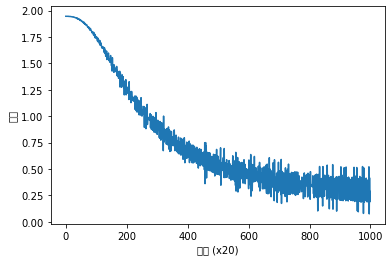

you [ 1.0540565 -0.9927385  1.7241259 -1.0279038 -1.0776054]
say [-1.39129     0.0837824   0.29990438  0.396457    1.3731437 ]
goodbye [ 1.0273771  -1.0832796  -0.8026497  -0.9638424  -0.98101395]
and [-1.2269883 -1.3348505  1.2813845 -1.3916426  1.2256435]
i [ 0.9855551  -1.0527047  -0.8242766  -0.93238103 -0.96565247]
hello [ 1.0591443 -0.9982393  1.7256993 -1.0445514 -1.0876963]
. [-1.1018516  1.2246237 -1.3656433  1.2209637  1.1328951]


In [32]:
import numpy as np

from common.trainer import Trainer
from common.optimizer import Adam
#from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam() # Adam 을 사용하여 매개변수 갱신
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])


## 3.5 word2vec 보충

## 3.6 정리

- 추론 기반 기법은 추측하는 것이 목적, 부산물로 단어의 분산 표현을 얻을 수 있다.
- word2vec은 추론 기반 기법, 단순한 2층 신경망이다
- word2vec은 skip-gram모델과 cbow모델을 제공한다
- cbow모델은 여러 단더(맥락)로부터 하나의 단어(타깃)을 추측한다
- 반대로 skip-gram 모델은 하나의 단어(타깃)로부터 다수의 단어(맥락)을 추측한다.
- word2vec은 가중치를 다시 학습할 수 있으므로, 단어의 분산 표현 갱신이나 새로운 단어 추가를 효율적으로 수행 가능하다